In [1]:
from utils_v1 import *

from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates, 
    MTDeforestationTime
)
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
import matplotlib.pyplot as plt
import matplotlib

from tifffile import imsave
import src.rasterHandler as rasterHandler


In [2]:
addPastDeforestationInput = True
# dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)
# threshold_uncertainty = 0.15
threshold_uncertainty = 0.1

dataset = MTDeforestationTime()
if type(dataset) != ParaMultipleDates:
	patchesHandler = PatchesHandler()
else:
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)

save_probabilities = True
loadInference = True

if type(dataset) == ParaMultipleDates:
	exp = 11 # Multiple dates. using fixed fixed past deforestation distance
	exp = 22
	exp = 50
	exp = 52
	# exp = 54
	exp = 56
	exp = 58
	# exp = 63
	# exp = 52
	# exp = 64
	# exp = 66
	exp = 66
	exp = 68
	# exp = 69
	# exp = 70
	exp = 72
if type(dataset) == MTDeforestationTime:
	exp = 28


In [3]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif
Mask label shape:  
 (16795, 10420) 
 Unique values:  
 [0 1 2]


(-0.5, 10419.5, 16794.5, -0.5)

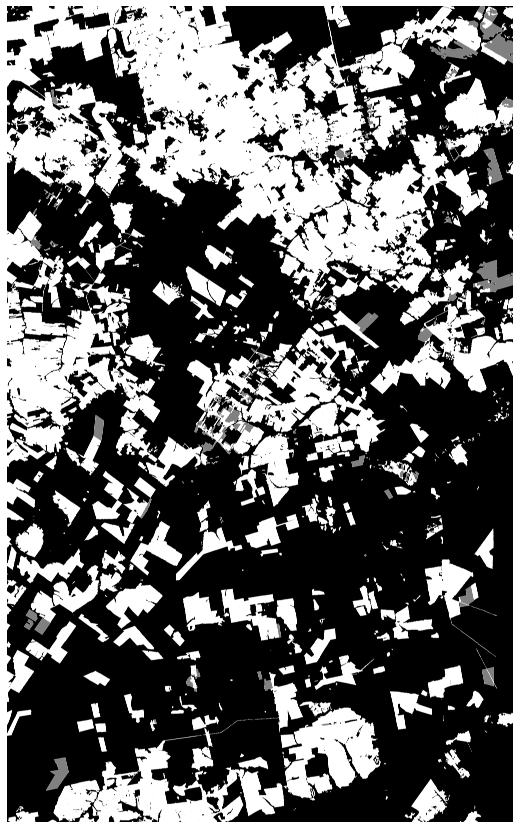

In [4]:
plt.figure(figsize=(15,15))
plt.imshow(label_mask, cmap=plt.cm.gray)
plt.axis('off')


In [5]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [6]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| np.unique(deforestation_time, return_counts=True): (array([0.        , 0.07692308, 0.15384616, 0.23076925, 0.30769232,
                                                              0.3846154 , 0.4615385 , 0.53846157, 0.61538464, 0.6923077 ,
                                                              0.7692308 , 0.84615386, 0.923077  , 1.        ], dtype=float32),
                                                        array([112663205,   2051611,   1054095,   1098902,   1007787,    876898,
                                                                 648966,    708580,    287191,    313901,    338545,    240796,
                                                                1332783,  52380640], dtype=int64))
ic| deforestation_time.shape: (16795, 10420, 1)
    image_stack.shape: (16795, 10420, 20)
ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420)


In [7]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (16795, 10420, 21)
ic| channels: 21


21

In [8]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [9]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [10]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [11]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/MT/exp28'

In [12]:
channels

21

In [13]:
image_stack.shape

(16795, 10420, 21)

In [14]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [15]:
#%% Test loop
times = 10

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
del image_stack


-5.0 -12.0


In [16]:


h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times), dtype = np.float32)

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,times):
            print('time: ', tm)

            new_model = build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
                nb_filters = nb_filters, n_classes = class_n)

            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            
            
            # Recinstructing predicted map
            start_test = time.time()

            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp28/models/resunet_0.h5'


In [17]:
del image1_pad


In [18]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, times), dtype = np.float32)

    for tm in range (0, times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
np.save(path_maps+'/prob_mean.npy', mean_prob)



0
1
2
3
4
5
6
7
8
9


In [19]:
ic(mean_prob.shape)

ic| mean_prob.shape: (16800, 10432)


(16800, 10432)

In [20]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]

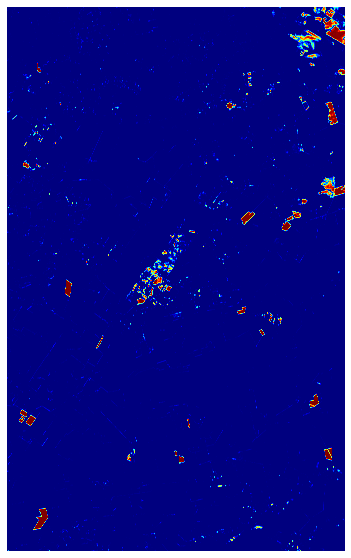

In [21]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [22]:
print(label_mask.shape)

(16795, 10420)


In [23]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(44666931,)
(array([0, 1], dtype=uint8), array([43791579,   875352], dtype=int64))


In [24]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (16800, 10432, 10)


In [25]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [26]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [27]:
print(mean_prob.shape)

# threshold = 0.420339
threshold = 0.5

predicted = np.zeros_like(mean_prob)

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0

print(np.unique(predicted, return_counts=True))

(16795, 10420)
(array([0., 1.], dtype=float32), array([172689691,   2314209], dtype=int64))


(-0.5, 10419.5, 16794.5, -0.5)

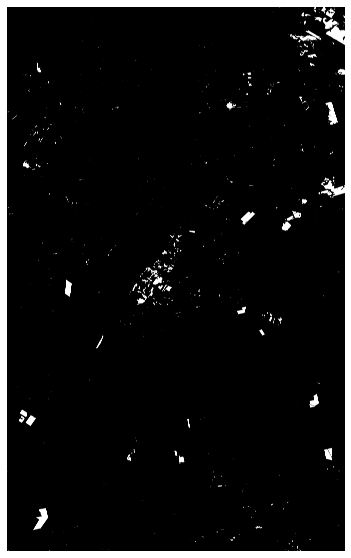

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(predicted, cmap = plt.cm.gray)
plt.axis('off')

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [30]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 16800, 10432, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.015181914
    np.max(prob_rec): 1.0


(0.0, 0.015181914, 1.0)

In [31]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [32]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.0059930156
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): -0.0
    np.mean(pred_entropy): 0.0065907342
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (16800, 10432)
    pred_entropy_to_show.shape: (16795, 10420)


((16800, 10432), (16795, 10420))

In [33]:
import utils_v1
label_mask_test = label_mask[mask_amazon_ts == 1]
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
y_pred = pred_entropy_test

In [34]:
ic(np.min(y_pred), np.mean(y_pred), np.max(y_pred))

ic| np.min(y_pred): -0.0
    np.mean(y_pred): 0.009217702
    np.max(y_pred): 0.36787948


(-0.0, 0.009217702, 0.36787948)

In [35]:
importlib.reload(_metrics)


predicted_thresholded = np.zeros_like(y_pred).astype(np.int8)
predicted_thresholded[y_pred >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (44666931,)


(44666931,)

In [36]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([43307050,  1359881], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([110023547,   2273209,  62707144], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64))


((array([0, 1], dtype=uint8), array([43307050,  1359881], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([110023547,   2273209,  62707144], dtype=int64)),
 (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64)))

In [37]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    # total_test_area = mask_test.copy()
    # total_test_area[label_mask == 2] = 0
    total_test_area = mask_test[label_mask != 2] 
    total_test_area = total_test_area[total_test_area == 1]
    ic(uncertainty_mask.flatten().shape, total_test_area.shape)
    percentage = np.count_nonzero(uncertainty_mask.flatten()) / len(total_test_area.flatten())
    return total_test_area, percentage

ic(predicted_thresholded.shape, label_mask.shape, mask_amazon_ts.shape, label_mask.flatten().shape)
total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| predicted_thresholded.shape: (44666931,)
    label_mask.shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask.flatten().shape: (175003900,)
ic| uncertainty_mask.flatten().shape: (44666931,)
    total_test_area.shape: (44666931,)
ic| percentage: 0.030444916844633896


0.030444916844633896

In [38]:

pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)



uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1

ignoreSmallPolygons = False
if ignoreSmallPolygons == True:
    min_polygon_area = 625 # pixels
    ic(np.unique(uncertainty_mask, return_counts=True))

    uncertainty_mask_without_small_polygons = skimage.morphology.area_opening(uncertainty_mask, 
        area_threshold = min_polygon_area, connectivity=1)

    
ic(np.unique(uncertainty_mask, return_counts=True))



ic| pred_entropy_unpad.shape: (16795, 10420)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([171251873,   3752027], dtype=int64))


(array([0, 1], dtype=int8), array([171251873,   3752027], dtype=int64))

In [39]:
# cv2.imwrite("uncertainty_mask_without_small_polygons.png", uncertainty_mask_without_small_polygons*255)
# cv2.imwrite("uncertainty_mask.png", uncertainty_mask*255)


In [40]:
# ic(np.min(image_stack[...,[13,12,11]]), np.mean(image_stack[...,[13,12,11]]), np.max(image_stack[...,[13,12,11]]))


In [41]:
# plt.figure(figsize=(10,10))
# plt.imshow(image_stack[...,[13,12,11]])
# plt.axis('off')



In [42]:
# cv2.imwrite("MT_sentinel2_t0_rgb.png", image_stack[...,[3,2,1]])
## cv2.imwrite("MT_sentinel2_t0_rgb.png", (image_stack[...,[3,2,1]]*255).astype(np.uint8))
# cv2.imwrite("MT_sentinel2_t1_rgb.png", (image_stack[...,[13,12,11]]*255).astype(np.uint8))


In [43]:
# cv2.imwrite("MT_sentinel2_t0_rgb.png", (image_stack[...,[3,2,1]]*255).astype(np.uint8))

In [44]:
ic(pred_entropy_unpad.shape, label_mask.shape)

ic| pred_entropy_unpad.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)


((16795, 10420), (16795, 10420))

In [45]:
'''
def getUncertaintyMask(uncertainty):

    uncertainty_mask = np.zeros_like(uncertainty).astype(np.uint8)
    uncertainty_mask[uncertainty >= 0.15] = 1
    return uncertainty_mask
def maskOutPastDeforestation(uncertainty_mask, label_mask):
    uncertainty_mask[label_mask == 2] = 0
    return uncertainty_mask

uncertainty_mask = getUncertaintyMask(pred_entropy_unpad)
uncertainty_mask = maskOutPastDeforestation(uncertainty_mask, label_mask)
ic(np.unique(uncertainty_mask, return_counts=True))
'''

'\ndef getUncertaintyMask(uncertainty):\n\n    uncertainty_mask = np.zeros_like(uncertainty).astype(np.uint8)\n    uncertainty_mask[uncertainty >= 0.15] = 1\n    return uncertainty_mask\ndef maskOutPastDeforestation(uncertainty_mask, label_mask):\n    uncertainty_mask[label_mask == 2] = 0\n    return uncertainty_mask\n\nuncertainty_mask = getUncertaintyMask(pred_entropy_unpad)\nuncertainty_mask = maskOutPastDeforestation(uncertainty_mask, label_mask)\nic(np.unique(uncertainty_mask, return_counts=True))\n'

In [46]:
'''
uncertainty_mask_test = uncertainty_mask[mask_amazon_ts==1]
label_test = label_mask[mask_amazon_ts==1]

uncertainty_mask_test = uncertainty_mask_test[label_test!=2]

ic(uncertainty_mask_test.shape)
'''

'\nuncertainty_mask_test = uncertainty_mask[mask_amazon_ts==1]\nlabel_test = label_mask[mask_amazon_ts==1]\n\nuncertainty_mask_test = uncertainty_mask_test[label_test!=2]\n\nic(uncertainty_mask_test.shape)\n'

In [47]:
prob_rec.shape

(10, 16800, 10432, 1)

(-0.5, 10431.5, 16799.5, -0.5)

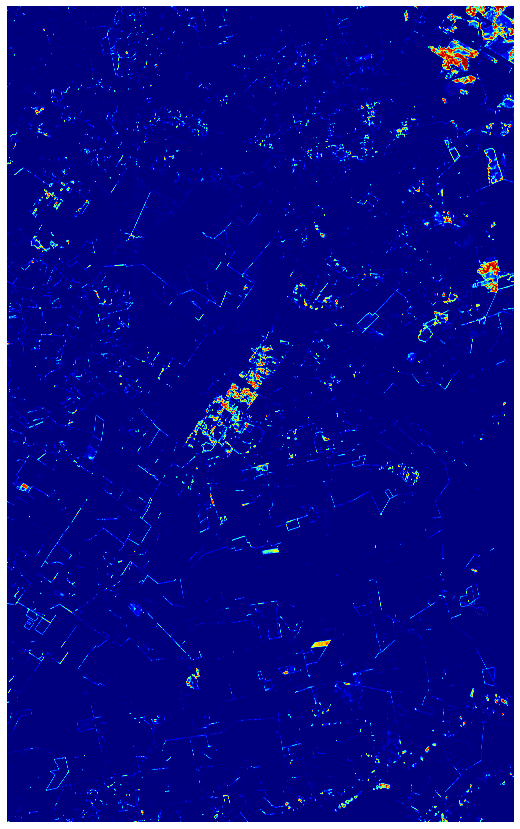

In [48]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy, cmap='jet')
plt.axis('off')


In [49]:
np.mean(pred_entropy)

0.0065907342

In [50]:
# mean_prob.shape
pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].shape

(16795, 10420)

In [51]:
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(pred_entropy): -0.0
    np.mean(pred_entropy): 0.0065907342
    np.max(pred_entropy): 0.36787948


(-0.0, 0.0065907342, 0.36787948)

In [52]:
predicted = np.zeros_like(mean_prob).astype(np.uint8)
threshold = 0.5
predicted[mean_prob>=threshold] = 1
min_polygon_area = 625
predicted_without_small_polygons = skimage.morphology.area_opening(predicted, 
        area_threshold = min_polygon_area, connectivity=1)

predicted_small_polygons = predicted - predicted_without_small_polygons


In [53]:
pred_entropy_to_show[predicted_small_polygons == 1] = 0
ic(pred_entropy_to_show.shape)

ic| pred_entropy_to_show.shape: (16795, 10420)


(16795, 10420)

(-0.5, 10419.5, 16794.5, -0.5)

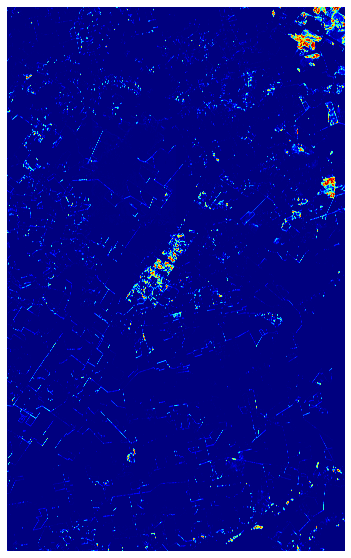

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


In [55]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.0058125346
    np.max(pred_entropy_to_show): 0.36787948


(0.0, 0.0058125346, 0.36787948)

In [56]:

georreferenced_save = False

In [57]:
import utils_v1
import rasterio

if georreferenced_save == True:
    georref_im = utils_v1.load_tiff_image('D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif')

In [58]:
if georreferenced_save == True:
    georref_im.shape

In [65]:
ic(pred_entropy_unpad.shape, pred_entropy.shape)
ic(predicted.shape, label_mask.shape)

ic| pred_entropy_unpad.shape: (16795, 10420)
    pred_entropy.shape: (16800, 10432)


((16795, 10420), (16800, 10432))

In [77]:
prediced_to_show = predicted.copy()
prediced_to_show[label_mask == 2] = 0

label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

false_positive_mask = prediced_to_show - label_mask_current_deforestation
false_positive_mask = (false_positive_mask + 1).astype(np.int8)
ic(np.unique(false_positive_mask, return_counts=True))

ic| np.unique(false_positive_mask, return_counts=True): (array([0, 1, 2], dtype=int8),
                                                         array([   279367, 174404166,    320367], dtype=int64))


(array([0, 1, 2], dtype=int8),
 array([   279367, 174404166,    320367], dtype=int64))

In [73]:
if georreferenced_save == True:
    original_im_path = 'D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif'

## Save georreferenced images

In [65]:
if georreferenced_save == True:

    pred_entropy_to_show_pad = rasterHandler.padForGeorreferencing(pred_entropy_to_show)

    ic(np.min(pred_entropy_to_show_pad), np.mean(pred_entropy_to_show_pad), np.max(pred_entropy_to_show_pad))

    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(pred_entropy_to_show_pad, cmap='jet')
    plt.axis('off')

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_uncertainty_georreferenced.tif'
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(pred_entropy_to_show_pad, axis=0).astype(np.float32), produced_im_path, bands = 1,
                    nodata=-1)

In [78]:
if georreferenced_save == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_false_positive_mask_georreferenced.tif'
    false_positive_mask_pad = rasterHandler.padForGeorreferencing(false_positive_mask, pad_value = 255)
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(false_positive_mask_pad, axis=0).astype(np.uint8), produced_im_path, bands = 1,
                    nodata=255, dtype = rasterio.uint8)

ic| im.shape: (16795, 10420)
ic| im_pad.shape: (16798, 10420)
ic| im_pad.shape: (20798, 13420)


In [66]:
if georreferenced_save == True:

    label_mask_pad = rasterHandler.padForGeorreferencing(label_mask, pad_value = 255)
    label_mask_pad.dtype

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_ground_truth_georreferenced.tif'
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(label_mask_pad, axis=0).astype(np.uint8), produced_im_path, bands = 1,
                    nodata=255, dtype = rasterio.uint8)

    predicted_pad = rasterHandler.padForGeorreferencing(predicted, pad_value = 255)
    predicted_pad.dtype
    predicted_pad[label_mask_pad == 2] = 2

    ic(np.unique(predicted_pad, return_counts=True))

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_predicted_georreferenced.tif'
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(predicted_pad, axis=0).astype(np.uint8), produced_im_path, bands = 1,
                    nodata=255, dtype = rasterio.uint8)

                

In [67]:

if georreferenced_save == True:

    im_t0_pad = rasterHandler.padForGeorreferencingChannels(image_stack[...,[3,2,1]])
    im_t0_pad = np.transpose(im_t0_pad, (2, 0, 1))
    print(np.min(image_stack[...,[13,12,11]]), np.mean(image_stack[...,[13,12,11]]), np.max(image_stack[...,[13,12,11]]))


    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_sentinel2_2019_rgb_georreferenced.tif'
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_t0_pad.astype(np.float32), produced_im_path, bands = 3,
                    nodata=-1)

    im_t1_pad = rasterHandler.padForGeorreferencingChannels(image_stack[...,[13,12,11]])
    im_t1_pad = np.transpose(im_t1_pad, (2, 0, 1))
    print(im_t1_pad.shape)

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/figures/MT_sentinel2_2020_rgb_georreferenced.tif'
    rasterHandler.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_t1_pad.astype(np.float32), produced_im_path, bands = 3,
                    nodata=-1)
    

In [ ]:
uncertainty_mask.dtype

In [ ]:


if georreferenced_save == True:
    uncertainty_mask_pad = rasterHandler.padForGeorreferencingChannels(uncertainty_mask)
    uncertainty_mask_pad = np.transpose(uncertainty_mask_pad, (2, 0, 1))

    uncertainty_mask_without_small_polygons_pad = rasterHandler.padForGeorreferencingChannels(
        uncertainty_mask_without_small_polygons)
    uncertainty_mask_without_small_polygons_pad = np.transpose(
        uncertainty_mask_without_small_polygons_pad, (2, 0, 1))

(-0.5, 10419.5, 16794.5, -0.5)

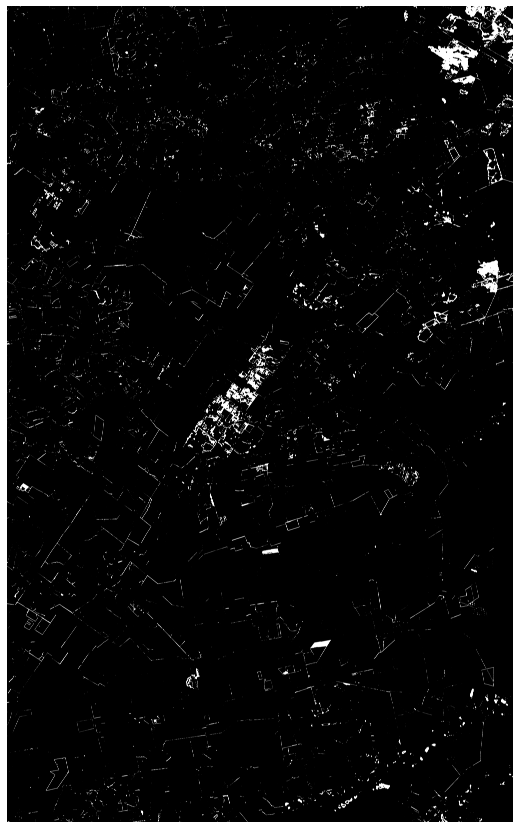

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [ ]:
ic(np.unique(uncertainty_mask, return_counts=True))

ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([171251873,   3752027], dtype=int64))


(array([0, 1], dtype=int8), array([171251873,   3752027], dtype=int64))

In [ ]:
# contours, _ = cv2.findContours(uncertainty_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE);

In [ ]:
# len(contours)

In [ ]:
# for con in contours:
#     area = cv2.contourArea(con);
#     print(area)

In [ ]:
connectivity = 4  
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    uncertainty_mask, connectivity, cv2.CV_32S)


In [ ]:
ic(num_labels)

ic| num_labels: 16629


16629

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(labels, cmap = plt.cm.gray)

Error in callback <function flush_figures at 0x00000293C23921F0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
area = stats[1:,-1]

In [ ]:
stats[44:55]

array([[ 2265,  1060,    36,   253,  2384],
       [ 2574,  1069,    84,    64,   682],
       [ 7211,  1075,   105,    47,   655],
       [ 6189,  1093,    27,    59,   762],
       [ 9945,  1102,    54,    36,   964],
       [ 2849,  1134,    34,    85,  1221],
       [ 5916,  1161,    40,    46,  1199],
       [ 3029,  1201,    66,    50,  1753],
       [ 6070,  1220,    37,    39,   882],
       [10324,  1273,    65,   120,  1022],
       [ 9016,  1285,   305,   219, 14787]], dtype=int32)

In [ ]:
ic(np.min(area),np.mean(area),np.max(area))

ic| np.min(area): 627
    np.mean(area): 3717.543316831683
    np.max(area): 270918


(627, 3717.543316831683, 270918)

In [ ]:
np.argmax(area)

31

In [ ]:
area.shape

(808,)

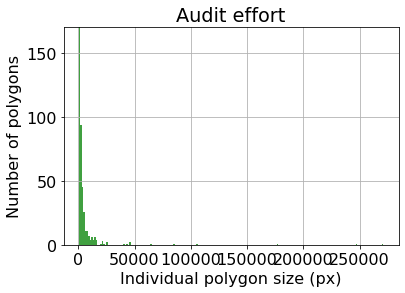

In [ ]:
import matplotlib.pyplot as plt
bin_n = 200
n, bins, patches = plt.hist(area, bin_n, facecolor='g', alpha=0.75)


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Number of polygons')
plt.title('Audit effort')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.xlim(-100, 2000)
plt.ylim(0, 170)
plt.grid(True)
plt.show()

In [ ]:
print(bins)

[   627.      1978.455   3329.91    4681.365   6032.82    7384.275
   8735.73   10087.185  11438.64   12790.095  14141.55   15493.005
  16844.46   18195.915  19547.37   20898.825  22250.28   23601.735
  24953.19   26304.645  27656.1    29007.555  30359.01   31710.465
  33061.92   34413.375  35764.83   37116.285  38467.74   39819.195
  41170.65   42522.105  43873.56   45225.015  46576.47   47927.925
  49279.38   50630.835  51982.29   53333.745  54685.2    56036.655
  57388.11   58739.565  60091.02   61442.475  62793.93   64145.385
  65496.84   66848.295  68199.75   69551.205  70902.66   72254.115
  73605.57   74957.025  76308.48   77659.935  79011.39   80362.845
  81714.3    83065.755  84417.21   85768.665  87120.12   88471.575
  89823.03   91174.485  92525.94   93877.395  95228.85   96580.305
  97931.76   99283.215 100634.67  101986.125 103337.58  104689.035
 106040.49  107391.945 108743.4   110094.855 111446.31  112797.765
 114149.22  115500.675 116852.13  118203.585 119555.04  120906

In [ ]:
# ic(bins, bins[2]-bins[1], bins[3]-bins[2], bins[4]-bins[3])
bin_size = round(bins[2]-bins[1], 1)
ic(bin_size)

ic| bin_size: 1351.5


1351.5

In [ ]:
import pdb
def getBinAreaSum(areas, bin_n, bin_size):
    areaSumPerBin = []
    for bin_id in range(bin_n):
        areaSum = 0
        for area in areas:
            if area > bin_size * bin_id and area < bin_size * (bin_id + 1):
                areaSum = areaSum + area
                # print(areaSum)
                # pdb.set_trace()
        areaSumPerBin.append(areaSum)
    return areaSumPerBin
        


areaSumPerBin = getBinAreaSum(area, bin_n, bin_size)    
ic(areaSumPerBin)

ic| areaSumPerBin: [397643,
                    345306,
                    220086,
                    133563,
                    105350,
                    58889,
                    95244,
                    49008,
                    80648,
                    63852,
                    87063,
                    46929,
                    33191,
                    0,
                    19951,
                    42423,
                    21730,
                    23110,
                    50650,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    41149,
                    0,
                    43426,
                    45454,
                    46386,
                    0,
                    0,
                    0,
                    0,
          

[397643,
 345306,
 220086,
 133563,
 105350,
 58889,
 95244,
 49008,
 80648,
 63852,
 87063,
 46929,
 33191,
 0,
 19951,
 42423,
 21730,
 23110,
 50650,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 41149,
 0,
 43426,
 45454,
 46386,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 65233,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 84724,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 104862,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 177257,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 247027,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
bins

array([   627.   ,   1978.455,   3329.91 ,   4681.365,   6032.82 ,
         7384.275,   8735.73 ,  10087.185,  11438.64 ,  12790.095,
        14141.55 ,  15493.005,  16844.46 ,  18195.915,  19547.37 ,
        20898.825,  22250.28 ,  23601.735,  24953.19 ,  26304.645,
        27656.1  ,  29007.555,  30359.01 ,  31710.465,  33061.92 ,
        34413.375,  35764.83 ,  37116.285,  38467.74 ,  39819.195,
        41170.65 ,  42522.105,  43873.56 ,  45225.015,  46576.47 ,
        47927.925,  49279.38 ,  50630.835,  51982.29 ,  53333.745,
        54685.2  ,  56036.655,  57388.11 ,  58739.565,  60091.02 ,
        61442.475,  62793.93 ,  64145.385,  65496.84 ,  66848.295,
        68199.75 ,  69551.205,  70902.66 ,  72254.115,  73605.57 ,
        74957.025,  76308.48 ,  77659.935,  79011.39 ,  80362.845,
        81714.3  ,  83065.755,  84417.21 ,  85768.665,  87120.12 ,
        88471.575,  89823.03 ,  91174.485,  92525.94 ,  93877.395,
        95228.85 ,  96580.305,  97931.76 ,  99283.215, 100634.

In [ ]:
matplotlib.rcParams.update({'font.size': 16})


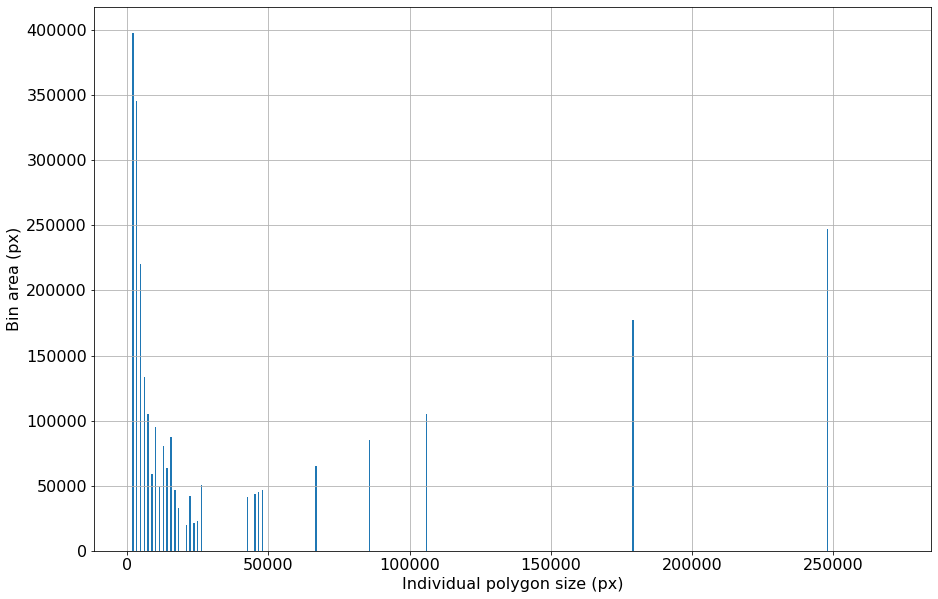

In [ ]:

plt.figure(figsize = (15,10))
width = 500
plt.bar(bins[1:], areaSumPerBin, width)


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Bin area (px)')
# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
plt.grid(True)
plt.savefig('figures/polygon_area_sum_per_bin.png', dpi=150, bbox_inches='tight')

In [ ]:
ic(bins.shape, n.shape)

ic| bins.shape: (201,), n.shape: (200,)


((201,), (200,))

In [ ]:
ic(np.sum(n))

ic(np.sum(n) - n[0])

ic| np.sum(n): 808.0
ic| np.sum(n) - n[0]: 235.0


235.0

In [ ]:
bins[1:]

array([  1978.455,   3329.91 ,   4681.365,   6032.82 ,   7384.275,
         8735.73 ,  10087.185,  11438.64 ,  12790.095,  14141.55 ,
        15493.005,  16844.46 ,  18195.915,  19547.37 ,  20898.825,
        22250.28 ,  23601.735,  24953.19 ,  26304.645,  27656.1  ,
        29007.555,  30359.01 ,  31710.465,  33061.92 ,  34413.375,
        35764.83 ,  37116.285,  38467.74 ,  39819.195,  41170.65 ,
        42522.105,  43873.56 ,  45225.015,  46576.47 ,  47927.925,
        49279.38 ,  50630.835,  51982.29 ,  53333.745,  54685.2  ,
        56036.655,  57388.11 ,  58739.565,  60091.02 ,  61442.475,
        62793.93 ,  64145.385,  65496.84 ,  66848.295,  68199.75 ,
        69551.205,  70902.66 ,  72254.115,  73605.57 ,  74957.025,
        76308.48 ,  77659.935,  79011.39 ,  80362.845,  81714.3  ,
        83065.755,  84417.21 ,  85768.665,  87120.12 ,  88471.575,
        89823.03 ,  91174.485,  92525.94 ,  93877.395,  95228.85 ,
        96580.305,  97931.76 ,  99283.215, 100634.67 , 101986.

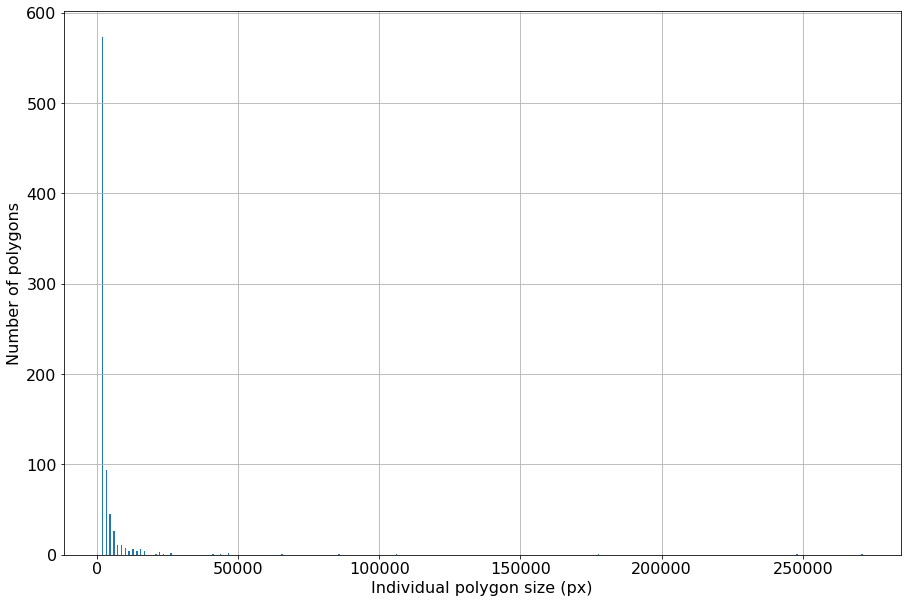

In [ ]:

plt.figure(figsize = (15,10))
plt.bar(bins[1:], n, width)


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Number of polygons')
# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
plt.grid(True)
plt.savefig('figures/polygon_bin_area.png', dpi=150, bbox_inches='tight')

In [ ]:
def getCumulativeArea(areaSumPerBin):
    cumulativeArea = []
    cumulativeSum = 0
    for areaSum in areaSumPerBin[::-1]:
        cumulativeSum = cumulativeSum + areaSum
        cumulativeArea.append(cumulativeSum)
    return np.asarray(cumulativeArea)[::-1]



cumulativeArea = getCumulativeArea(areaSumPerBin)
ic(cumulativeArea.shape)

ic| cumulativeArea.shape: (200,)


(200,)

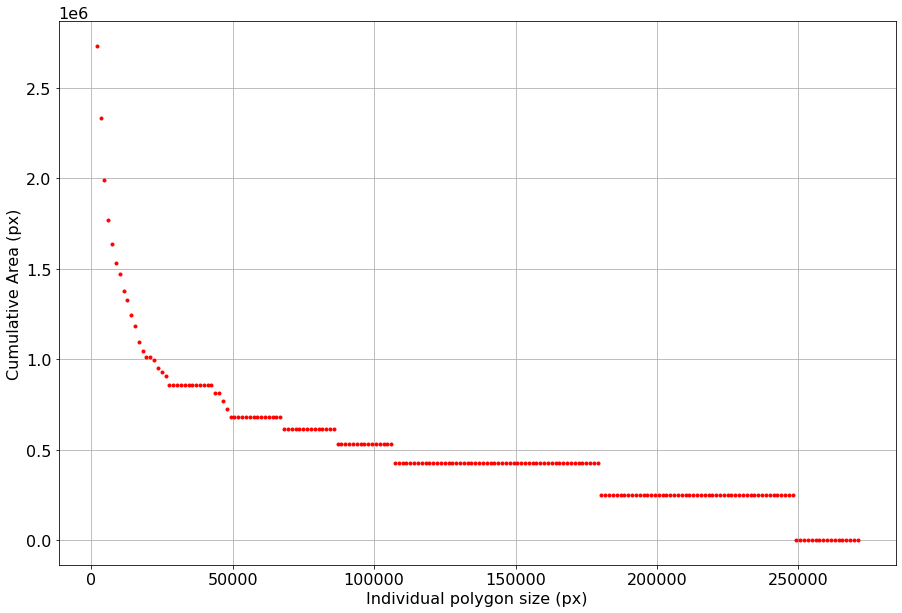

In [ ]:

plt.figure(figsize = (15,10))
plt.plot(bins[1:], cumulativeArea,'r.')


plt.xlabel('Individual polygon size (px)')
plt.ylabel('Cumulative Area (px)')
# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
plt.grid(True)
plt.savefig('figures/polygon_cumulative_area.png', dpi=150, bbox_inches='tight')

<Figure size 1080x720 with 0 Axes>

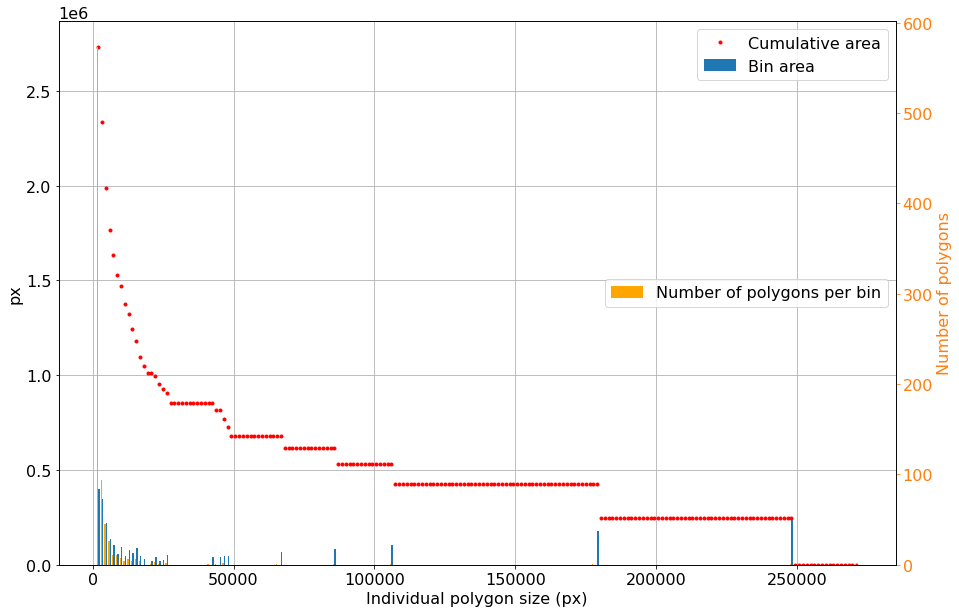

In [ ]:


plt.figure(figsize = (15,10))

# plt.bar(bins[1:], n, width)
# plt.bar(bins[1:] + width, np.asarray(areaSumPerBin)/50, width)

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax2 = ax1.twinx()

ax1.bar(bins[1:]+width/2, areaSumPerBin, width, label = 'Bin area')
ax1.plot(bins[1:], cumulativeArea,'r.', label = 'Cumulative area')

ax1.set_xlabel('Individual polygon size (px)')
ax1.set_ylabel('px')
ax1.legend(loc = 'upper right')

ax2.bar(bins[1:]-width/2, n, width, color = 'orange', label = 'Number of polygons per bin')
ax2.legend(loc = 'center right')
ax2.set_ylabel('Number of polygons', color="C1")
ax2.tick_params(axis='y', colors='C1')

# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
ax1.grid(True)
plt.savefig('figures/polygon_analysis.png', dpi=150, bbox_inches='tight')

<Figure size 1080x720 with 0 Axes>

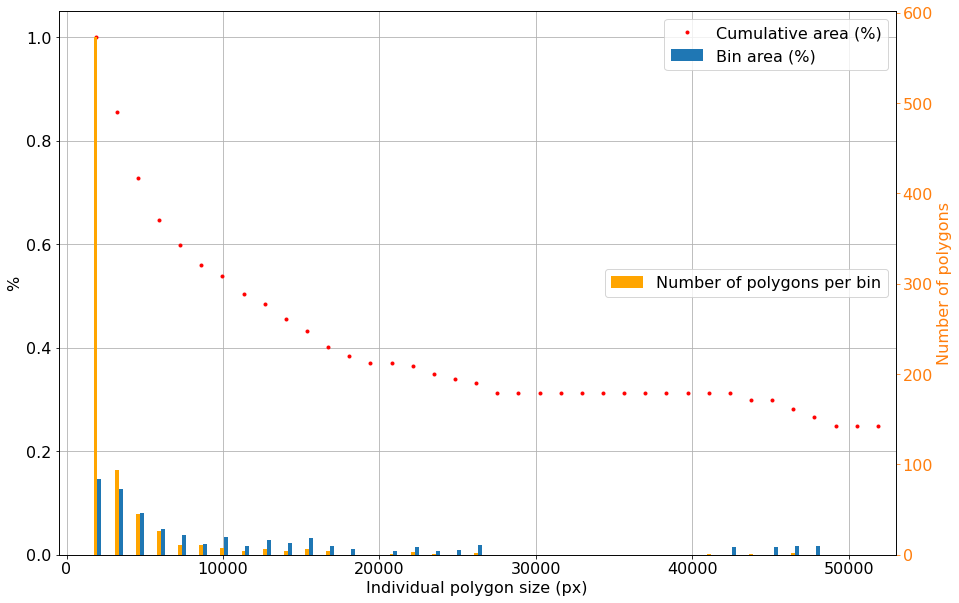

In [ ]:


plt.figure(figsize = (15,10))
width = 250
# plt.bar(bins[1:], n, width)
# plt.bar(bins[1:] + width, np.asarray(areaSumPerBin)/50, width)

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax2 = ax1.twinx()

ax1.bar(bins[1:]+width/2, areaSumPerBin/cumulativeArea[0], width, label = 'Bin area (%)')
ax1.plot(bins[1:]-width/2, cumulativeArea/cumulativeArea[0],'r.', label = 'Cumulative area (%)')

ax1.set_xlabel('Individual polygon size (px)')
ax1.set_ylabel('%')
ax1.legend(loc = 'upper right')

ax2.bar(bins[1:]-width/2, n, width, color = 'orange', label = 'Number of polygons per bin')
ax2.legend(loc = 'center right')
ax2.set_ylabel('Number of polygons', color="C1")
ax2.tick_params(axis='y', colors='C1')

ax1.set_xlim([-500, 53000])
ax2.set_xlim([-500, 53000])

# plt.title('Audit effort')
# plt.xlim(-100, 2000)
# plt.ylim(0, 170)
ax1.grid(True)
plt.savefig('figures/polygon_analysis_percentage.png', dpi=150, bbox_inches='tight')

In [ ]:
ic(np.sum(n), np.sum(n[1:]), np.sum(n[2:]))


ic| np.sum(n): 808.0, np.sum(n[1:]): 235.0, np.sum(n[2:]): 141.0


(808.0, 235.0, 141.0)

In [ ]:
ic(labels.shape, label_mask.shape)

ic| labels.shape: (16795, 10420), label_mask.shape: (16795, 10420)


((16795, 10420), (16795, 10420))

(-0.5, 10419.5, 16794.5, -0.5)

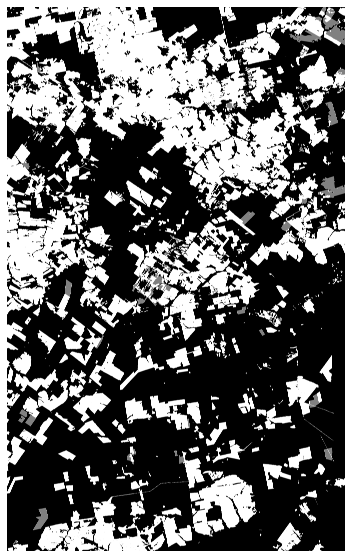

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap=plt.cm.gray)
plt.axis('off')

(-0.5, 10419.5, 16794.5, -0.5)

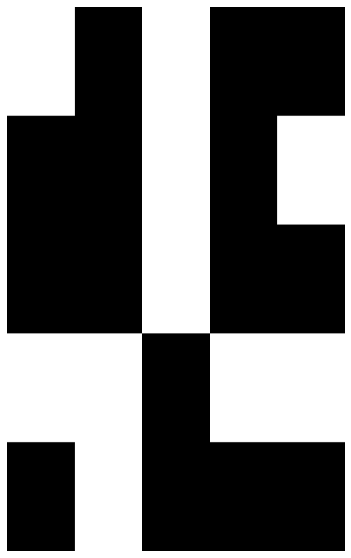

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(mask_amazon_ts, cmap=plt.cm.gray)
plt.axis('off')


(-0.5, 10419.5, 16794.5, -0.5)

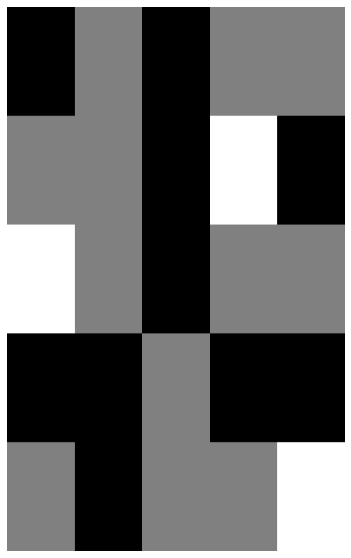

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val, cmap=plt.cm.gray)
plt.axis('off')


In [ ]:
label_current_deforestation = label_mask.copy()
label_current_deforestation[label_current_deforestation == 2] = 0
label_current_deforestation = label_current_deforestation.astype(np.bool)

C:\Users\jchamorro\AppData\Local\Temp\ipykernel_17376\2548657025.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_current_deforestation = label_current_deforestation.astype(np.bool)


In [ ]:
ic(np.unique(uncertainty_mask, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))


ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([172000125,   3003775], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([110023547,   2273209,  62707144], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64))


((array([0, 1], dtype=int8), array([172000125,   3003775], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([110023547,   2273209,  62707144], dtype=int64)),
 (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64)))

In [ ]:
'''
plt.figure(figsize=(10,10))
plt.imshow(total_test_area, cmap=plt.cm.gray)
plt.axis('off')
'''

"\nplt.figure(figsize=(10,10))\nplt.imshow(total_test_area, cmap=plt.cm.gray)\nplt.axis('off')\n"

In [ ]:
def countIntersectingPolygons(labels, deforestation_polygons):
    ic(np.max(labels))
    count_intersecting_polygons = 0

    for polygon_id in range(np.max(labels)):
        if polygon_id % 500 == 0:
            print(polygon_id, count_intersecting_polygons)
        polygon_mask = labels.copy()
        polygon_mask[polygon_mask != polygon_id] = 0
        polygon_mask = polygon_mask.astype(np.bool)

        
        if np.any(polygon_mask & deforestation_polygons):
            count_intersecting_polygons += 1
    return count_intersecting_polygons

# count_intersecting_polygons = countIntersectingPolygons(labels, label_current_deforestation)
count_intersecting_polygons = countIntersectingPolygons(labels, predicted.astype(np.bool))

ic(count_intersecting_polygons)

C:\Users\jchamorro\AppData\Local\Temp\ipykernel_17376\4215946958.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  count_intersecting_polygons = countIntersectingPolygons(labels, predicted.astype(np.bool))
ic| np.max(labels): 808


0 0


C:\Users\jchamorro\AppData\Local\Temp\ipykernel_17376\4215946958.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  polygon_mask = polygon_mask.astype(np.bool)


500 309


ic| count_intersecting_polygons: 434


434

In [ ]:
count_intersecting_polygons/np.max(labels)

0.5371287128712872